In [ ]:
# Импорт библиотек
from datetime import datetime

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Выгрузка данных из таблицы с тренировочными данными
train_data: np.ndarray = pd.read_csv("/content/drive/MyDrive/Данные для конкурса ОБРАБОТКА/DATA/train_data_r.csv", header=None).values

# Выгрузка данных из таблицы с тестовыми данными
test_data: np.ndarray = pd.read_csv("/content/drive/MyDrive/Данные для конкурса ОБРАБОТКА/DATA/test_data_r.csv", header=None).values

# Удаление заголовков
train_data = train_data[1:-1]
test_data = test_data[1:-1]


def time_st(date_str: str) -> str:
  return date_str[:13]

def days_since_zero_date(date_str: str) -> int:
  # Преобразование строки в объект datetime
  date_format: str = "%Y-%m-%d %H"
  date_obj = datetime.strptime(date_str, date_format)

  # Нулевая дата
  zero_date = datetime.strptime("2019-01-01 00", date_format)

  # Вычисление разницы в днях
  delta = date_obj - zero_date
  days = delta.days

  return days


train_data[:, :1] = np.vectorize(time_st)(train_data[:, :1])
test_data[:, :1] = np.vectorize(time_st)(test_data[:, :1])

# Применяем ранее определенную функцию ко всем датам датасета
train_data[:, :1] = np.vectorize(days_since_zero_date)(train_data[:, :1])
test_data[:, :1] = np.vectorize(days_since_zero_date)(test_data[:, :1])

train_data = train_data.astype("float")
test_data = test_data.astype("float")

X_train = train_data[:, :42]
y_train = train_data[:, 42]

X_test = test_data[:, :42]
y_test = test_data[:, 42]

<ipython-input-92-a56adcb631a1>:9: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data: np.ndarray = pd.read_csv("/content/drive/MyDrive/Данные для конкурса ОБРАБОТКА/DATA/train_data_r.csv", header=None).values


In [ ]:
pd.read_csv("/content/drive/MyDrive/Данные для конкурса ОБРАБОТКА/DATA/train_data_r.csv", header=None)

In [ ]:
train = pd.concat([pd.DataFrame(X_train), pd.DataFrame({'y': y_train})], axis=1)#.fillna(0)
test = pd.concat([pd.DataFrame(X_test), pd.DataFrame({'y': y_test})], axis=1)#.fillna(0)
end_test = np.array(test)[8z091:8591] #500
test = pd.DataFrame(np.array(test)[:8091])
test = test.rename(columns={42: 'y'})

DATA = pd.concat([train, test], axis=0)
DATA = DATA.sample(frac=1).reset_index(drop=True)

k = DATA.shape[0]

X = DATA.drop(['y'], axis = 1)
Y = DATA['y']

train_r_X = np.array(list(np.array(X))[:int(0.75*k)])
train_r_Y = np.array(list(np.array(Y))[:int(0.75*k)])

test_r_X = np.array(list(np.array(X))[int(0.75*k):k])
test_r_Y = np.array(list(np.array(Y))[int(0.75*k):k])


X_train = train_r_X
y_train = train_r_Y

X_test = test_r_X
y_test = test_r_Y

X_end = end_test[:, :42]
Y_end = end_test[:, 42]

In [ ]:
import lightgbm as lgb

print("Размеры Train/Test: ", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

train_dataset = lgb.Dataset(X_train, y_train)
test_dataset = lgb.Dataset(X_test, y_test)

booster = lgb.train({"objective": "regression"},
                    train_set=train_dataset, valid_sets=(test_dataset,),
                    num_boost_round=500)

Размеры Train/Test:  (31542, 42) (10514, 42) (31542,) (10514,)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 31542, number of used features: 42
[LightGBM] [Info] Start training from score 958.898835


In [ ]:
preds = booster.predict(X_test, pred_contrib=True)
preds_r = []
for i in preds:
  preds_r.append(i.sum())
preds = np.array(preds_r)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [04:04:31] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [04:04:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


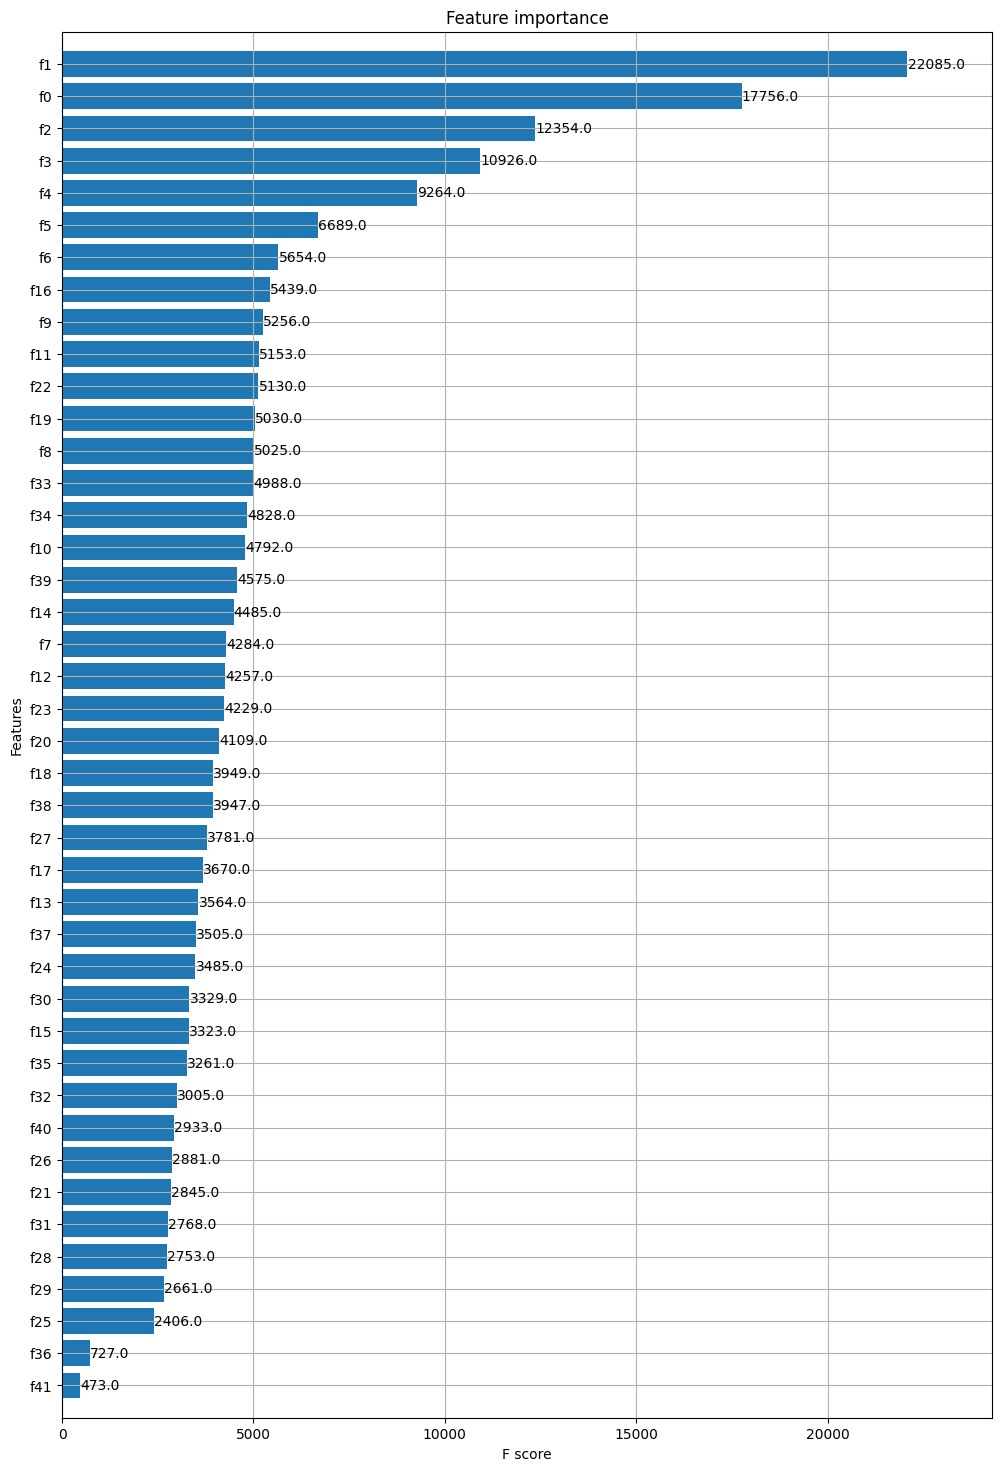

In [ ]:
import xgboost as xgb
xgb_params = {
    'eta': 0.25,
    'max_depth': 11,
    'subsample': 1,
    'colsample_bytree': 1,
    'objective': 'reg:linear',
    'silent': 1,
    'seed' : 0
}
dtrain = xgb.DMatrix(X_train, y_train)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=500)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [ ]:
preds = model.predict(xgb.DMatrix(X_test))

In [ ]:
from sklearn import ensemble
model = ensemble.ExtraTreesRegressor(n_estimators=50, max_depth=30, max_features=0.7, n_jobs=-1, random_state=0)
model.fit(X_train, y_train)

preds = model.predict(X_test)

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 8.5 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.01,
    depth=2
)

model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose=35
)

0:	learn: 93.4451962	test: 92.9528156	best: 92.9528156 (0)	total: 16ms	remaining: 15.9s
35:	learn: 73.7204982	test: 73.3192289	best: 73.3192289 (35)	total: 408ms	remaining: 10.9s
70:	learn: 59.9500286	test: 59.6738426	best: 59.6738426 (70)	total: 814ms	remaining: 10.6s
105:	learn: 50.4183344	test: 50.2361840	best: 50.2361840 (105)	total: 1.16s	remaining: 9.82s
140:	learn: 43.9337843	test: 43.8094639	best: 43.8094639 (140)	total: 1.34s	remaining: 8.17s
175:	learn: 39.5634738	test: 39.4529448	best: 39.4529448 (175)	total: 1.51s	remaining: 7.08s
210:	learn: 36.6789060	test: 36.5810080	best: 36.5810080 (210)	total: 1.67s	remaining: 6.25s
245:	learn: 34.7812024	test: 34.6768924	best: 34.6768924 (245)	total: 1.83s	remaining: 5.62s
280:	learn: 33.5248738	test: 33.4308203	best: 33.4308203 (280)	total: 2.01s	remaining: 5.14s
315:	learn: 32.6868104	test: 32.5987653	best: 32.5987653 (315)	total: 2.17s	remaining: 4.7s
350:	learn: 32.1035205	test: 32.0148561	best: 32.0148561 (350)	total: 2.33s	rema

In [ ]:
preds = model.predict(X_test)

In [ ]:
def induction(data):
  del_num = data.shape[0] % 24
  return data[:-del_num]

#preds = np.array(eval_data['Сибирь']) - np.array(preds)
y_mean = induction(y_test).reshape(357, 24)#(np.array(eval_data['Сибирь']) - np.array(eval_labels)).reshape(357, 24)
y_mean_r = []
for i in range(len(y_mean)):
  y_mean_r.append(y_mean[i].mean())

y_preds_mean = induction(preds).reshape(357, 24)
y_preds_mean_r = []
for i in range(len(y_preds_mean)):
  y_preds_mean_r.append(y_preds_mean[i].mean())
y_mean_r = np.array(y_mean_r)
y_preds_mean_r = y_preds_mean_r = np.array(y_preds_mean_r)

#y_mean_r, y_preds_mean_r

ValueError: cannot reshape array of size 10368 into shape (357,24)

In [ ]:
y_test = Y_end
preds = model.predict(xgb.DMatrix(X_end))

In [ ]:
y_mean_r = y_test
y_preds_mean_r = preds

In [ ]:
X_train[1][2], y_train[0]
o = []
for i in range(0, len(X_train)):
  o.append(X_train[i][2])

In [ ]:
o = np.array(o)
o, y_train

(array([928.10144928, 928.10144928, 928.10144928, ..., 983.19047619,
        983.19047619, 983.19047619]),
 array([ 934.02941176,  934.02941176,  922.83823529, ...,  959.14285714,
         959.14285714, 1008.31868132]))

In [ ]:
y_mean_r = y_train
y_preds_mean_r = o

In [ ]:
import matplotlib.pyplot as mtp
mtp.plot(y_mean_r, color="green", linewidth=1)
mtp.plot(y_preds_mean_r, color="red", linewidth=1)
mtp.title("really_price - green, predicted_price - red")
mtp.xlabel("Дни (с 05.12.2022 до 26.11.2023)")
mtp.ylabel("Цена, ₽")
mtp.show()
#mtp.savefig('/content/sample_data/Test.png', dpi=100)

NameError: name 'y_mean_r' is not defined

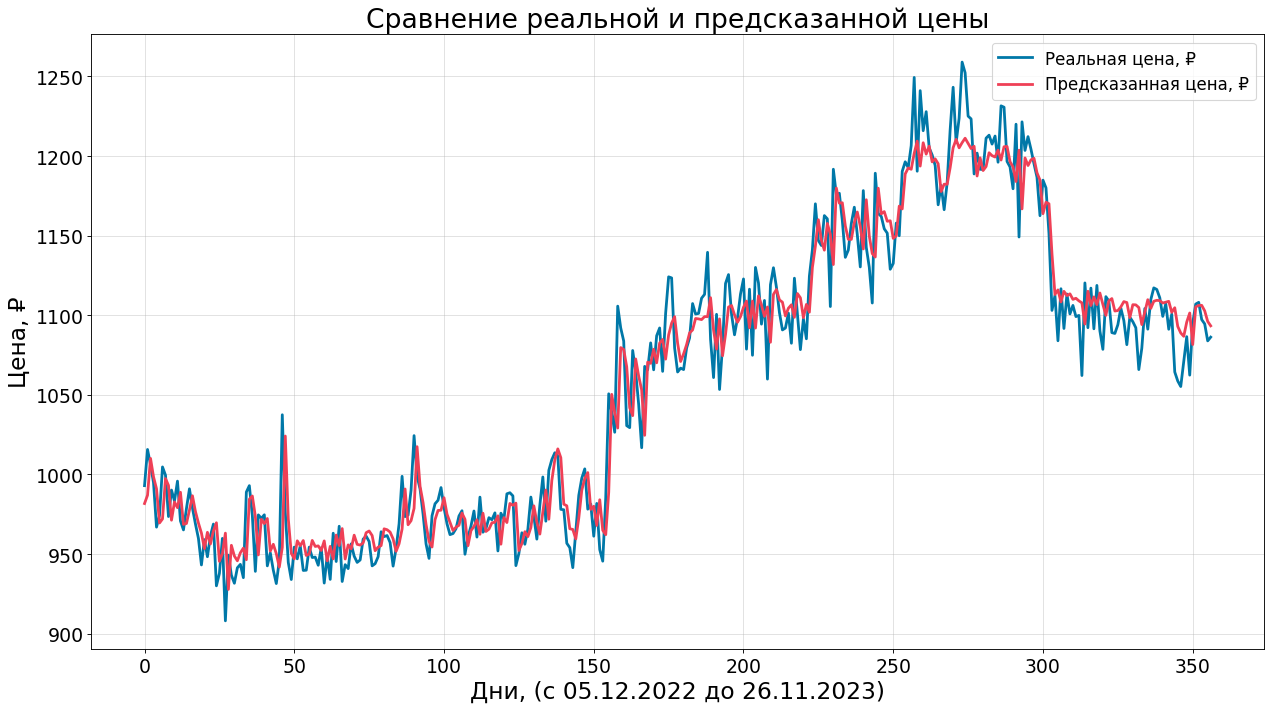

In [ ]:
# Import Data
#df = pd.read_csv("https://github.com/selva86/datasets/raw/master/economics.csv")

#x = df['date']
#y1 = df['psavert']
#y2 = df['unemploy']
x = [x for x in range(0, 357)]
y2 = y_mean_r
y1 = y_preds_mean_r

# Plot Line1 (Left Y Axis)
fig, ax1 = plt.subplots(1,1,figsize=(16 ,9), dpi= 80)
ax1.plot(x, y2, color='#0078A8', label='Реальная цена, ₽', linewidth=2.5)
ax1.plot(x, y1, color='#EF4056', label='Предсказанная цена, ₽', linewidth=2.5)

# Plot Line2 (Right Y Axis)
#ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
#ax2.plot(x, y2, color='tab:blue')

# Decorations
# ax1 (left Y axis)
ax1.set_xlabel('Дни, (с 05.12.2022 до 26.11.2023)', fontsize=21)
#ax1.set_xlabel('Последние 500 часов данных, (с 07.11.2023-3:00 до 27.11.2023-23:00)', fontsize=15)
ax1.tick_params(axis='x', rotation=0, labelsize=17)
ax1.tick_params(axis='y', rotation=0, labelsize=17)
ax1.set_ylabel("Цена, ₽", fontsize=21)
#ax1.set_ylabel('Предсказанна цена, ₽', color='tab:red', fontsize=20)
#ax1.tick_params(axis='y', rotation=0, labelcolor='tab:red' )
ax1.grid(alpha=.4)

# ax2 (right Y axis)
'''ax2.set_ylabel("Реальная цена, ₽", color='tab:blue', fontsize=20)
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.set_xticks(np.arange(0, len(x), 60))
ax2.set_xticklabels(x[::60], rotation=90, fontdict={'fontsize':10})'''
ax1.set_title("Сравнение реальной и предсказанной цены", fontsize=24)
fig.tight_layout()
plt.legend(loc='best', fontsize=15)
plt.show()

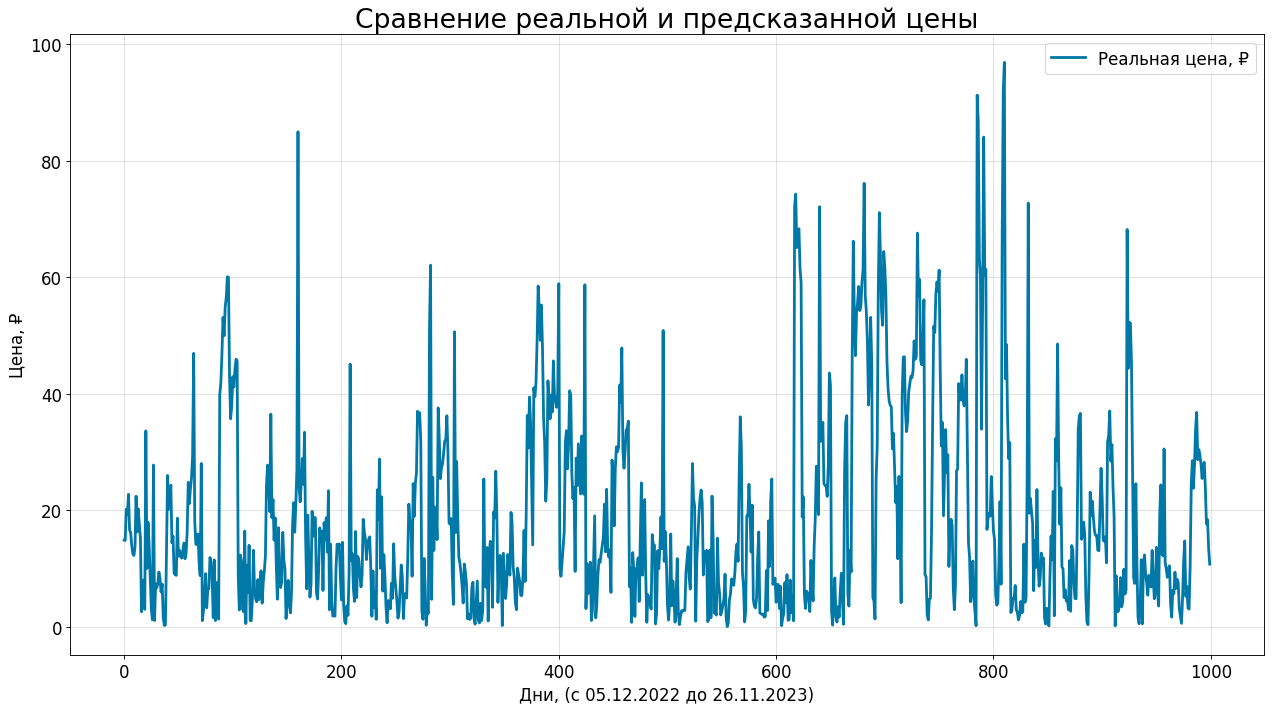

In [ ]:
x = [x for x in range(0, 1000)]
y2 = Y_end
try:
  y1 = model.predict(xgb.DMatrix(X_end))
except:
  y1 = model.predict(X_end)

# Plot Line1 (Left Y Axis)
fig, ax1 = plt.subplots(1,1,figsize=(16 ,9), dpi= 80)
ax1.plot(x, abs(y2-y1), color='#0078A8', label='Реальная цена, ₽', linewidth=2.5)
#ax1.plot(x, y1, color='#EF4056', label='Предсказанная цена, ₽', linewidth=2.5)

# Plot Line2 (Right Y Axis)
#ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
#ax2.plot(x, y2, color='tab:blue')

# Decorations
# ax1 (left Y axis)
#ax1.set_xlabel('Дни, (с 05.12.2022 до 26.11.2023)', fontsize=15)
ax1.set_xlabel('Последние 500 часов данных, (с 07.11.2023-3:00 до 27.11.2023-23:00)', fontsize=15)
ax1.tick_params(axis='x', rotation=0, labelsize=15)
ax1.tick_params(axis='y', rotation=0, labelsize=15)
ax1.set_ylabel("Цена, ₽", fontsize=15)
#ax1.set_ylabel('Предсказанна цена, ₽', color='tab:red', fontsize=20)
#ax1.tick_params(axis='y', rotation=0, labelcolor='tab:red' )
ax1.grid(alpha=.4)

# ax2 (right Y axis)
'''ax2.set_ylabel("Реальная цена, ₽", color='tab:blue', fontsize=20)
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.set_xticks(np.arange(0, len(x), 60))
ax2.set_xticklabels(x[::60], rotation=90, fontdict={'fontsize':10})'''
ax1.set_title("Сравнение реальной и предсказанной цены", fontsize=24)
fig.tight_layout()
plt.legend(loc='best', fontsize=15)
plt.show()

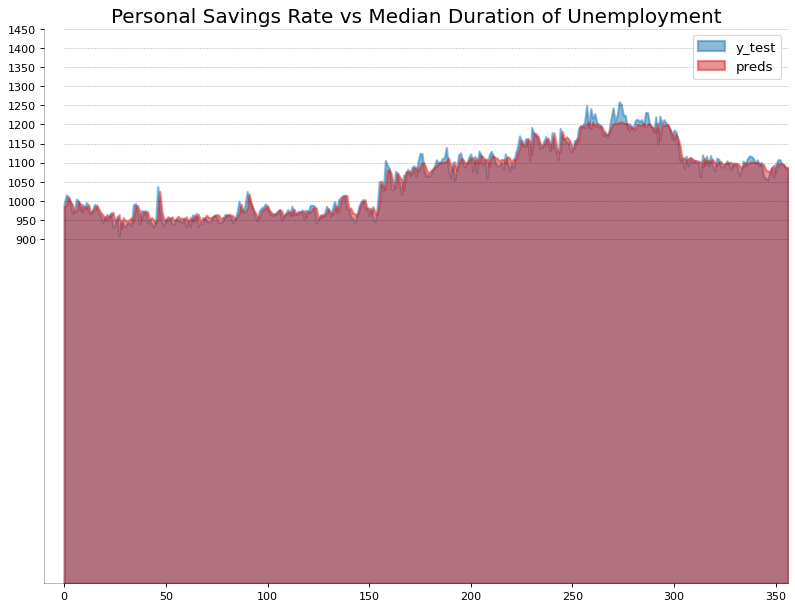

In [ ]:
df = pd.read_csv("https://github.com/selva86/datasets/raw/master/economics.csv")

# Prepare Data
x = df['date'].values.tolist()
y1 = df['psavert'].values.tolist()
y2 = df['uempmed'].values.tolist()
x = [x for x in range(0, 357)]
y1 = y_mean_r
y2 = y_preds_mean_r
mycolors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:brown', 'tab:grey', 'tab:pink', 'tab:olive']
columns = ['preds', 'y_test']

# Draw Plot
fig, ax = plt.subplots(1, 1, figsize=(12,9), dpi= 80)
ax.fill_between(x, y1=y1, y2=0, label=columns[1], alpha=0.5, color=mycolors[1], linewidth=2)
ax.fill_between(x, y1=y2, y2=0, label=columns[0], alpha=0.5, color=mycolors[0], linewidth=2)

# Decorations
ax.set_title('Personal Savings Rate vs Median Duration of Unemployment', fontsize=18)
ax.set(ylim=[0, 30])
ax.legend(loc='best', fontsize=12)
plt.xticks(x[::50], fontsize=10, horizontalalignment='center')
plt.yticks(np.arange(900, 1500.0, 50), fontsize=10)
plt.xlim(-10, x[-1])

# Draw Tick lines
for y in np.arange(900, 1500.0, 50):
    plt.hlines(y, xmin=0, xmax=len(x), colors='black', alpha=0.3, linestyles="--", lw=0.5)

# Lighten borders
plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(.3)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
import math
math.sqrt(mean_squared_error(y_test, preds)) # Среднеквадратичное отклонение

17.234181502391905

In [ ]:
(math.sqrt(mean_squared_error(y_test, preds))/ (sum(y_test)/(len(y_test))))*100 # Погрешность в процентах первым способом - оставить

1.8012690283975885

In [ ]:
y_test = Y_end
try:
  preds = model.predict(xgb.DMatrix(X_end))
except:
  preds = model.predict(X_end)

math.sqrt(mean_squared_error(y_test, preds)) # Среднеквадратичное отклонение

25.232576656151046

In [ ]:
(math.sqrt(mean_squared_error(y_test, preds))/ (sum(y_test)/(len(y_test))))*100 # Погрешность в процентах первым способом - оставить

1.8012690283975885

In [ ]:
# Погрешность в процентах вторым способом
g = []
for r, p in zip(y_test, preds):
  g.append(abs(r-p))

(sum(g)/len(g))/(sum(y_test)/len(y_test))*100

1.525996061936044

In [ ]:
y_test[315], preds[315]

(931.912087912088, 970.8765281669052)

In [ ]:
def accur(y, p, gran=10):
  answ = []
  for n in range(len(y)):
      answ.append(abs(y[n]-p[n]))

  good = 0
  bad = 0
  for i in answ:
    if i <= gran:
      good += 1
    else:
      bad += 1

  return good, bad, good/(bad + good)

accur(y_test, preds, 15) # 35 - это +- 35 рублей ошибка предсказния. При таком раскладе точность предсказания ~50%. Это значит, что в половине случаев цена уложится в границу, а в половине случаев - нет.

(338, 162, 0.676)

In [ ]:
# Определяем функцию ошибки
def MAE(predictions: np.ndarray, labels: np.ndarray) -> float:
    return np.mean(np.abs(predictions - labels))

# Выводим значение ошибки
#print(MAE(train_normalize_class.DeNormalizeData(model(test_data[:, :42]).numpy().T[0], axes=[0]) + np.random.normal(size=test_data[:, 42].shape), test_data[:, 42:]))
print(MAE(preds, y_test))

16.637693853837177


In [ ]:
from scipy.stats import pearsonr as KK
b = []
for i in range(len(X_train)):
  for n in range(42):
      kk = KK(X_train[n][i], y_train.reshape(1, -1)[0])[0]
      b.append(kk)
  print(f'Коэффициент корреляции {i}: {kk}')
print(max(b))

TypeError: object of type 'numpy.float64' has no len()